In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
aberdeen = [-4, -2, 55.5, 57.5]
uk = [-10.5, 9.5, 45.5, 61.3] # longitude min, longitude max, latitude min, latitude max

def bootstrap_sample(data, n_iterations=100):
    """Bootstrap resampling with replacement.""" 
    means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iterations)
    ])
    return np.percentile(means, [2.5, 97.5])  # 95% confidence interval

In [4]:
def calc_precip_scaling(t2m, tp, latitude_name = 'latitude', longitude_name = 'longitude', climate='1950'):
    """
    Function to calculate the scaling of precipitation with temperature. Averaging over area first

    Parameters
    ----------
    t2m : xarray DataArray
        Temperature data for the region of interest. Needs to have dimension climate.
    tp : xarray DataArray
        Precipitation data for the region of interest. Needs to have dimension climate.
    latitude_name : str
        Name of the latitude dimension in the DataArray. 
    longitude_name : str
        Name of the longitude dimension in the DataArray.
    climate : str, optional
        Climate scenario to compare against. The default is '1950'.

    Returns
    -------
    scaling_factor : xarray DataArray
        Scaling factor for precipitation with temperature.
    """
    
    # Calculate the mean temperature and precipitation
    mean_t2m = t2m.mean(dim=[latitude_name, longitude_name])
    mean_tp = tp.mean(dim=[latitude_name, longitude_name])

    # Calculate change in temperature over Aberdeenshire
    t2m_present = mean_t2m.sel(climate='present')
    t2m_climate = mean_t2m.sel(climate=climate)
    delta_t2m = t2m_present - t2m_climate

    # Calculate fractional precipitation change
    tp_present = mean_tp.sel(climate='present')
    tp_climate = mean_tp.sel(climate=climate)
    delta_tp = (tp_present - tp_climate)/tp_present

    # Calculate the scaling factor
    scaling_factor = delta_tp / delta_t2m
    return scaling_factor


In [5]:
color_palette = get_palette.Petroff6().to_sn_palette()

In [6]:
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

# Load data and post-process

In [7]:
# ERA5 analogues
era5_analogues = bb.data.Data.get_era5_analogues()
era5_analogues_tp = era5_analogues['tp'].sel(lat=slice(aberdeen[3], aberdeen[2]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon'])

# RACMO analogues
racmo_msl, racmo_tp = bb.data.Data.get_racmo_analogues()
racmo_tp = racmo_tp['tp'].sel(lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon'])

# PGW 
pgw = bb.data.Data.get_pgw_ensemble()
pgw_tp = (((pgw.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))*3*3600).sum(dim='time'))/1e5).sel(lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon'])

# FBA IFS
ifs = bb.data.Data.get_fba_ifs()
ifs_tp = ((ifs.tp.sel(time='2023-10-22 00') - ifs.tp.sel(time='2023-10-19 00'))*1000).sel(latitude=slice(aberdeen[3], aberdeen[2]), longitude=slice(aberdeen[0], aberdeen[1])).mean(dim=['latitude', 'longitude'])

# FBA MICAS
micas = bb.data.Data.get_fba_micas()
micas_tp = (micas.tp.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).sum(dim='time')*24*3600).mean(dim=['lat', 'lon'])

Importing data from pre-existing file
Importing data from pre-existing file
Importing data from pre-existing file
Importing data from pre-existing file


In [11]:
# For uncertainty estimates, we need the individual analogues from RACMO
racmo_individual_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_RACMO_2023-10-20_pr_individual_analogs_SCOT_1991-2020__1951-1980.nc')

da = racmo_individual_analogues.sel(period='1951-1980')
group = (np.arange(da.sizes['time']) // 16)
tmp1= da.groupby(xr.DataArray(group, dims='time')).mean('time').precip.expand_dims({'climate': ['1950']})

da = racmo_individual_analogues.sel(period='1991-2020')
group = (np.arange(da.sizes['time']) // 16)
tmp2= da.groupby(xr.DataArray(group, dims='time')).mean('time').precip.expand_dims({'climate': ['present']})

racmo_individual_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_RACMO_2023-10-20_pr_individual_analogs_SCOT_2071-2100__1991-2020.nc')
da = racmo_individual_analogues.sel(period='2071-2100')
group = (np.arange(da.sizes['time']) // 16)
tmp3= da.groupby(xr.DataArray(group, dims='time')).mean('time').precip.expand_dims({'climate': ['future1']})
racmo_analogues_tp = xr.concat([tmp1, tmp2, tmp3], dim='climate')


# Global temperatures differences

In [12]:
# ERA5
era5_globalmean_past = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_mean_fields/ERA_t2m_past.nc').mean(dim=['lat', 'lon'])
era5_globalmean_present = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_mean_fields/ERA_t2m_prst.nc').mean(dim=['lat', 'lon'])

era5_diff_t2m = era5_globalmean_past.t2m - era5_globalmean_present.t2m # 1950 to present difference only

In [13]:
# ACCESS MICAS

In [14]:
# PGW -- temperature difference the same in all ensemble members
pgw_diff_t2m = xr.DataArray(
    data=[-1.5, 0, 1.5, 3],
    dims=['climate'],
    coords={'climate': ['1870', 'present', 'future1', 'future2']}
)

In [15]:
# IFS
ifs_glob = bb.data.Data.get_global_ifs().sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim=['time', 'latitude', 'longitude'])
ifs_diff_t2m = ifs_glob.t2m - ifs_glob.t2m.sel(climate='present')

/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi/GLO100/sfc/pf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi_1950/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi_1950/GLO100/sfc/pf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/GLO100/sfc/pf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/incr/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/incr/GLO100/sfc/pf/*.nc


In [16]:
# RACMO
racmo_diff_t2m = xr.DataArray(
    data=[-0.6568695208333324, 0, 3.124064645833334],
    dims=['climate'],
    coords={'climate': ['1950', 'present', 'future1']}
)

In [17]:
# Probabilistic
prob_diff_t2m = xr.DataArray(
    data=[-1.5, 1.5],
    dims=['climate'],
    coords={'climate': ['1870', 'future1']}
)

# Testing different calculations

In [79]:
# Slice latitude and longitude just once
region_t2m = ifs.t2m.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using local ABD temperatures")
print(scaling_factors)

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invali

Precipitation scaling using local ABD temperatures
{'1870': array([[            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [15]:
# Slice latitude and longitude just once
region_t2m = ifs.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'))
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using UK temperatures")
print(scaling_factors)

Precipitation scaling using UK temperatures
{'1870': array([-0.60658985,  0.10509308], dtype=float32), '1950': array([-0.14231068,  0.0939611 ], dtype=float32), 'future1': array([2.0398295 , 0.02380418], dtype=float32)}


In [20]:
ifs_ = bb.data.Data.get_fba_ifs()
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

# Slice latitude and longitude just once
region_t2m = ifs_.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'), time=slice(starttime, endtime)).mean(dim='time')
region_tp = ifs_.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'), time=slice(starttime, endtime)).mean(dim='time')

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using European temperatures")
print(scaling_factors)

Precipitation scaling using European temperatures
{'1870': array([0.00228653, 0.1133773 ], dtype=float32), '1950': array([0.09381542, 0.10747275], dtype=float32), 'future1': array([0.3311451 , 0.12129134], dtype=float32)}


In [21]:
# Load gloabl data
glob_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/GLO100/sfc/pf'
glob_file_dir = {'curr': glob_dir.format('curr'),
            'pi': glob_dir.format('pi'),
            'incr': glob_dir.format('incr')}
climates = ['1870', 'present', 'future1']
tmp = []
for e, exp in enumerate(['pi', 'curr', 'incr']):
    tmp.append(xr.open_mfdataset(os.path.join(glob_file_dir[exp], '*.nc'), preprocess=bb.data.Data.preproc_ds, engine='netcdf4').expand_dims(climate=[climates[e]]))
ifs_glob = xr.concat(tmp, dim='climate')

In [22]:
# Slice latitude and longitude just once
region_t2m = ifs_glob.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'), time=slice(starttime, endtime)).mean(dim='time')
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870','future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using global temperatures")
print(scaling_factors)

Precipitation scaling using global temperatures
{'1870': array([-0.19274288,  0.11758389], dtype=float32), 'future1': array([0.22639696, 0.05634849], dtype=float32)}


# Precipitation scaling using global temperatures

## ERA5 analogues

In [18]:
def bootstrap_scaling_3(counterfac, factual, diff_t2m, n=10000):
        bootstrap_past = [np.mean(np.random.choice(counterfac, size=len(counterfac.values), replace=True)) for _ in range(n)]
        bootstrap_present = [np.mean(np.random.choice(factual, size=len(factual.values), replace=True)) for _ in range(n)]
        bootstrap_scaling = (np.array(bootstrap_past) - np.array(bootstrap_present))/np.array(bootstrap_present)/diff_t2m.values
        bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])

        return bootstrap_scaling

In [20]:
# ERA5 analogues
tp_diff = (era5_analogues_tp.sel(climate='1950') - era5_analogues_tp.sel(climate='present')).mean()/era5_analogues_tp.sel(climate='present').mean()
precip_scaling = tp_diff/era5_diff_t2m

print("ERA5 precip scaling")
print("Mean: ", precip_scaling.values)

# method 3
bootstrap_scaling = bootstrap_scaling_3(era5_analogues_tp.sel(climate='1950'), era5_analogues_tp.sel(climate='present'), era5_diff_t2m, n=10000)
print("95% CI: ", bootstrap_scaling)

ERA5 precip scaling
Mean:  0.12216272
95% CI:  [-0.24485298  0.37951901]


## Testing different bootstrap methods

In [41]:
# method 2
bootstrap_past = np.random.choice(era5_analogues_tp.sel(climate='1950'), size=10000, replace=True)
bootstrap_present = np.random.choice(era5_analogues_tp.sel(climate='present'), size=10000, replace=True)
bootstrap_scaling = (bootstrap_past - bootstrap_present)/bootstrap_present/era5_diff_t2m.values
bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])
print("95% CI: ", bootstrap_scaling)

95% CI:  [-28.82529259   0.9848392 ]


In [45]:
# method 3
bootstrap_past = [np.mean(np.random.choice(era5_analogues_tp.sel(climate='1950'), size=len(era5_analogues_tp.sel(climate='1950').values), replace=True)) for _ in range(100)]
bootstrap_present = [np.mean(np.random.choice(era5_analogues_tp.sel(climate='present'), size=len(era5_analogues_tp.sel(climate='present').values), replace=True)) for _ in range(100)]
bootstrap_scaling = (np.array(bootstrap_past) - np.array(bootstrap_present))/np.array(bootstrap_present)/era5_diff_t2m.values
bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])
print("95% CI: ", bootstrap_scaling)

95% CI:  [-0.31088729  0.36541901]


## IFS

In [48]:
# IFS 
for i, ini in enumerate(['2023-10-15', '2023-10-17']):
    for e, exp in enumerate(['1870', '1950', 'future1']):
        counterfac = ifs_tp.sel(inidate=ini, climate=exp)
        factual = ifs_tp.sel(inidate=ini, climate='present')
        tp_diff = (counterfac - factual).mean()/factual.mean()
        precip_scaling = tp_diff/ifs_diff_t2m.sel(climate=exp, inidate=ini).mean()
        print("IFS, Inidate: ", ini, ", climate: ", exp)
        print("Mean: ", precip_scaling.values)
        
        # method 3
        bootstrap_past = [np.mean(np.random.choice(counterfac, size=len(counterfac.values), replace=True)) for _ in range(10)]
        bootstrap_present = [np.mean(np.random.choice(factual, size=len(factual.values), replace=True)) for _ in range(10)]
        bootstrap_scaling = (np.array(bootstrap_past) - np.array(bootstrap_present))/np.array(bootstrap_present)/ifs_diff_t2m.sel(climate=exp, inidate=ini).mean().values
        bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])
        print("95% CI: ", bootstrap_scaling)

IFS, Inidate:  2023-10-15 , climate:  1870
Mean:  -0.036932934
95% CI:  [-0.18778958  0.07713455]
IFS, Inidate:  2023-10-15 , climate:  1950
Mean:  -0.080550574
95% CI:  [-0.25616157  0.11460953]
IFS, Inidate:  2023-10-15 , climate:  future1
Mean:  0.068440504
95% CI:  [-0.03510034  0.16944664]
IFS, Inidate:  2023-10-17 , climate:  1870
Mean:  0.14801799
95% CI:  [0.07831209 0.20501146]
IFS, Inidate:  2023-10-17 , climate:  1950
Mean:  0.11781483
95% CI:  [0.06800599 0.2725924 ]
IFS, Inidate:  2023-10-17 , climate:  future1
Mean:  0.04829093
95% CI:  [0.00319771 0.12814376]


In [53]:
# PGW 
for exp in ['1870', 'future1', 'future2']:
    tp_diff = (pgw_tp.sel(climate=exp) - pgw_tp.sel(climate='present')).mean()/pgw_tp.sel(climate='present').mean()
    precip_scaling = tp_diff/pgw_diff_t2m.sel(climate=exp).mean()
    print("PGW, climate: ", exp)
    print("Mean: ", precip_scaling.values)

    bootstrap_scaling = bootstrap_scaling_3(pgw_tp.sel(climate=exp), pgw_tp.sel(climate='present'), pgw_diff_t2m.sel(climate=exp), n=10000)
    print("95% CI: ", bootstrap_scaling)

PGW, climate:  1870
Mean:  0.005686473101377487
95% CI:  [-0.18969973  0.15212135]
PGW, climate:  future1
Mean:  0.013606312374273935
95% CI:  [-0.18678755  0.27188819]
PGW, climate:  future2
Mean:  0.14533000191052756
95% CI:  [-0.02056006  0.344125  ]


In [ ]:
# ACCESS MICAS
# for exp in ['1870', 'future1']:
#     tp_diff = (micas_tp.sel(climate=exp) - micas_tp.sel(climate='present')).mean()/micas_tp.sel(climate='present').mean()
#     precip_scaling = tp_diff/micas_diff_t2m.sel(climate=exp).mean()
#     print("MICAS, climate: ", exp)
#     print("Mean: ", precip_scaling.values)

#     bootstrap_scaling = bootstrap_scaling_3(micas_tp.sel(climate=exp), micas_tp.sel(climate='present'), micas_diff_t2m.sel(climate=exp), n=10000)
#     print("95% CI: ", bootstrap_scaling)

In [97]:
# RACMO analogues
for e, exp in enumerate(['1950', 'future1']):
    # tp_diff = (racmo_tp.sel(climate=exp) - racmo_tp.sel(climate='present'))/racmo_tp.sel(climate='present')
    # precip_scaling = tp_diff/racmo_diff_t2m.sel(climate=exp).mean()
    tp_diff = (racmo_analogues_tp.sel(climate=exp) - racmo_analogues_tp.sel(climate='present')).mean()/racmo_analogues_tp.sel(climate='present').mean()
    precip_scaling = tp_diff/racmo_diff_t2m.sel(climate=exp).mean()
    print("RACMO, climate: ", exp)
    print("Mean: ", precip_scaling.values)

    bootstrap_scaling = bootstrap_scaling_3(racmo_analogues_tp.sel(climate=exp), racmo_analogues_tp.sel(climate='present'), racmo_diff_t2m.sel(climate=exp), n=10000)
    print("95% CI: ", bootstrap_scaling)

RACMO, climate:  1950
Mean:  0.08264001694750962
95% CI:  [-0.0376686   0.19218331]
RACMO, climate:  future1
Mean:  0.021480910151787845
95% CI:  [-0.00327698  0.04839332]


# Results from all methods

In [21]:
from matplotlib import colors


# stats = [{'med': 16.8, 'q1': -17.0, 'q3': 60.3, 'whislo' : 0, 'whishi': 0},  # ERA5 analogues
        #  {'med': 10.34, 'q1': 6.38, 'q3': 13.09, 'whislo' : 0, 'whishi': 0},  # PGW past
        #  {'med': 10.99, 'q1': 3.85, 'q3': 21.13, 'whislo' : 0, 'whishi': 0},  # PGW FUT1
        #  {'med': 9.55, 'q1': 4.63, 'q3': 16.68, 'whislo' : 0, 'whishi': 0},  # PGW FUT2
        #  {'med': -25.2, 'q1': -41.6, 'q3': -8.7, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 15
        #  {'med': 46.5, 'q1': 13.3, 'q3': 84.6, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 15
        #  {'med': 13.6, 'q1': 9.4, 'q3': 17.6, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 17
        #  {'med': 14.4, 'q1': 7.1, 'q3': 21.7, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 17
stats = [{'med': 12.21, 'q1': -25.11, 'q3': 37.87, 'whislo' : 0, 'whishi': 0},  # ERA5 analogues
         {'med': 8.26, 'q1': -3.77, 'q3': 19.2, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, past
         {'med': 2.14, 'q1': -0.32, 'q3': 4.84, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, future
         {'med': 0.57, 'q1': -18.96, 'q3': 15.21, 'whislo' : 0, 'whishi': 0},  # PGW past
         {'med': 1.36, 'q1': -18.67, 'q3': 27.19, 'whislo' : 0, 'whishi': 0},  # PGW FUT1
         {'med': 14.533, 'q1': -2.10, 'q3': 34.4, 'whislo' : 0, 'whishi': 0},  # PGW FUT2
         {'med': -3.69, 'q1': -18.97, 'q3': 7.71, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 15
         {'med': 6.84, 'q1': -3.51, 'q3': 16.94, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 15
         {'med': 14.80, 'q1': 7.83, 'q3': 20.50, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 17
         {'med': 4.83, 'q1': 0.31, 'q3': 12.81, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 17
         {'med': 12.9, 'q1': 12.9, 'q3': 12.9, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, future
         {'med': -8.7, 'q1': -8.7, 'q3': -8.7, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, past
         {'med': 7.19, 'q1': -11.06, 'q3': 31.03, 'whislo' : 0, 'whishi': 0},   # Probabilistic past
         {'med': 1.96, 'q1': -3.69, 'q3': 7.43, 'whislo' : 0, 'whishi': 0}] # Probabilistic future

# To help with plotting
g = 1.5  # Space between groups
b = 0.5  # Space within groups
labels = ['ERA5 analogues', 
          'RACMO analogues, past', 'RACMO analogues, future',
          'PGW, past -1.5K', 'PGW, future +1.5K', 'PGW, future +3K', 
          'FBA IFS, past, init 15th', 'FBA IFS, future, init 15th', 'FBA IFS, past, init 17th', 'FBA IFS, future, init 17th', 
          'FBA ACCESS, future', 'FBA ACCESS, past', 
          'Probabilistic, past', 'Probabilistic, future']
positions = [b, # ERA5 analogues
             b+g, 2*b+g, # RACMO analogues
             b+2*g, 2*b+2*g, 3*b+2*g, # PGW
             3*b+3*g, 4*b+3*g, 5*b+3*g, 6*b+3*g, # FBA IFS
             6*b+4*g, 7*b+4*g, # FBA ACCESS
             7*b+5*g, 8*b+5*g] # Probabilistic
colour_options = [ color_palette[4], color_palette[1]]  #["gray", "darkorange"]
colors = [colour_options[0], # ERA5 analogues
          colour_options[0], colour_options[1], # RACMO analogues
          colour_options[0], colour_options[1], colour_options[1], # PGW 
          colour_options[0], colour_options[1], colour_options[0], colour_options[1], # FBA IFS
          colour_options[0], colour_options[1], # FBA ACCESS
          colour_options[0], colour_options[1]] # Probabilistic

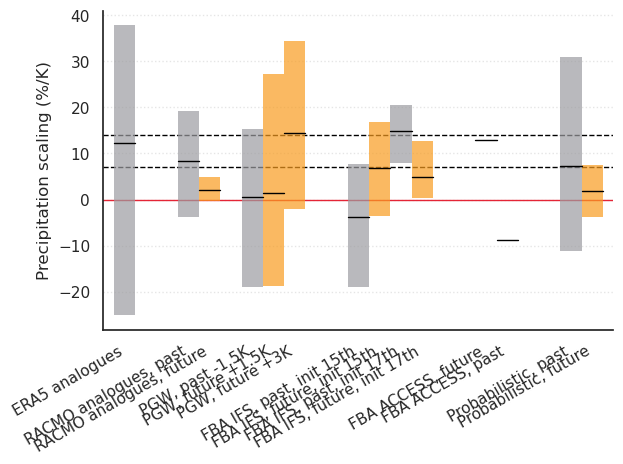

In [22]:
# https://stackoverflow.com/questions/54033076/can-i-generate-a-boxplot-without-a-dataset-and-only-having-the-relevant-values

# Main plot
_, ax = plt.subplots();

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axhline(y=7, color='black', linestyle='--', linewidth=1)
plt.axhline(y=14, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color=color_palette[2], linestyle='-', linewidth=1)

boxplot = ax.bxp(stats, showfliers=False, 
              showcaps=False, 
              whiskerprops={'linestyle': ''}, 
              medianprops={'linestyle': '-', 'color': 'black'}, 
              boxprops={'linestyle': '', 'alpha': 0.7},
              patch_artist=True,
              positions=positions);

# Apply colors
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Plot settings
plt.ylabel("Precipitation scaling (%/K)")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, ha='right')
sns.despine()
plt.tight_layout()
# Add a faint grid in dotted lines
plt.grid(axis='y', linestyle=':', alpha=0.5)

plt.savefig("figures/PAPER3_precip_scaling_boxplot.png", dpi=600, bbox_inches='tight')
plt.savefig("figures/PAPER3_precip_scaling_boxplot.pdf")

# Different order

Text(0.5, 1.0, 'ordered by decreasing conditioning')

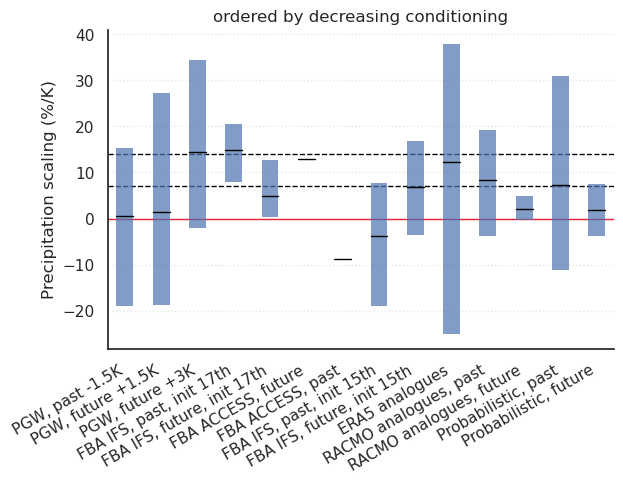

In [49]:
from matplotlib import colors

stats = [{'med': 0.57, 'q1': -18.96, 'q3': 15.21, 'whislo' : 0, 'whishi': 0},  # PGW past
         {'med': 1.36, 'q1': -18.67, 'q3': 27.19, 'whislo' : 0, 'whishi': 0},  # PGW FUT1
         {'med': 14.533, 'q1': -2.10, 'q3': 34.4, 'whislo' : 0, 'whishi': 0},  # PGW FUT2
         {'med': 14.80, 'q1': 7.83, 'q3': 20.50, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 17
         {'med': 4.83, 'q1': 0.31, 'q3': 12.81, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 17
         {'med': 12.9, 'q1': 12.9, 'q3': 12.9, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, future
         {'med': -8.7, 'q1': -8.7, 'q3': -8.7, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, past
         {'med': -3.69, 'q1': -18.97, 'q3': 7.71, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 15
         {'med': 6.84, 'q1': -3.51, 'q3': 16.94, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 15
         {'med': 12.21, 'q1': -25.11, 'q3': 37.87, 'whislo' : 0, 'whishi': 0},  # ERA5 analogues
         {'med': 8.26, 'q1': -3.77, 'q3': 19.2, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, past
         {'med': 2.14, 'q1': -0.32, 'q3': 4.84, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, future
         {'med': 7.19, 'q1': -11.06, 'q3': 31.03, 'whislo' : 0, 'whishi': 0},   # Probabilistic past
         {'med': 1.96, 'q1': -3.69, 'q3': 7.43, 'whislo' : 0, 'whishi': 0}] # Probabilistic future

# To help with plotting
labels = ['PGW, past -1.5K', 'PGW, future +1.5K', 'PGW, future +3K', 
          'FBA IFS, past, init 17th', 'FBA IFS, future, init 17th', 
          'FBA ACCESS, future', 'FBA ACCESS, past', 
          'FBA IFS, past, init 15th', 'FBA IFS, future, init 15th',
          'ERA5 analogues', 
          'RACMO analogues, past', 'RACMO analogues, future',
          'Probabilistic, past', 'Probabilistic, future']
positions = np.linspace(0, len(stats), len(stats))

# Main plot
_, ax = plt.subplots();

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axhline(y=7, color='black', linestyle='--', linewidth=1)
plt.axhline(y=14, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color=color_palette[2], linestyle='-', linewidth=1)

boxplot = ax.bxp(stats, showfliers=False, 
              showcaps=False, 
              whiskerprops={'linestyle': ''}, 
              medianprops={'linestyle': '-', 'color': 'black'}, 
              boxprops={'linestyle': '', 'alpha': 0.7},
              patch_artist=True,
              positions=positions);

# Plot settings
plt.ylabel("Precipitation scaling (%/K)")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, ha='right')
sns.despine()
plt.tight_layout()
# Add a faint grid in dotted lines
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('ordered by decreasing conditioning')

Text(0.5, 1.0, 'ordered by future and past')

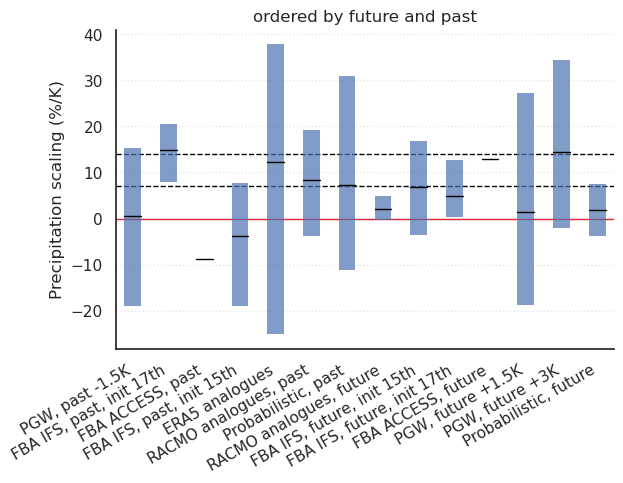

In [54]:
from matplotlib import colors

stats = [{'med': 0.57, 'q1': -18.96, 'q3': 15.21, 'whislo' : 0, 'whishi': 0},  # PGW past
         {'med': 14.80, 'q1': 7.83, 'q3': 20.50, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 17
         {'med': -8.7, 'q1': -8.7, 'q3': -8.7, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, past
         {'med': -3.69, 'q1': -18.97, 'q3': 7.71, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 15
         {'med': 12.21, 'q1': -25.11, 'q3': 37.87, 'whislo' : 0, 'whishi': 0},  # ERA5 analogues
         {'med': 8.26, 'q1': -3.77, 'q3': 19.2, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, past
         {'med': 7.19, 'q1': -11.06, 'q3': 31.03, 'whislo' : 0, 'whishi': 0},   # Probabilistic past
         {'med': 2.14, 'q1': -0.32, 'q3': 4.84, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, future
         {'med': 6.84, 'q1': -3.51, 'q3': 16.94, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 15
         {'med': 4.83, 'q1': 0.31, 'q3': 12.81, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 17
         {'med': 12.9, 'q1': 12.9, 'q3': 12.9, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, future
         {'med': 1.36, 'q1': -18.67, 'q3': 27.19, 'whislo' : 0, 'whishi': 0},  # PGW FUT1
         {'med': 14.533, 'q1': -2.10, 'q3': 34.4, 'whislo' : 0, 'whishi': 0},  # PGW FUT2
         {'med': 1.96, 'q1': -3.69, 'q3': 7.43, 'whislo' : 0, 'whishi': 0}] # Probabilistic future

# To help with plotting
labels = ['PGW, past -1.5K', 
          'FBA IFS, past, init 17th', 'FBA ACCESS, past', 
          'FBA IFS, past, init 15th', 
          'ERA5 analogues', 
          'RACMO analogues, past', 
          'Probabilistic, past', 
          'RACMO analogues, future',
          'FBA IFS, future, init 15th',
          'FBA IFS, future, init 17th', 
          'FBA ACCESS, future',
          'PGW, future +1.5K', 'PGW, future +3K',
          'Probabilistic, future']
positions = np.linspace(0, len(stats), len(stats))

# Main plot
_, ax = plt.subplots();

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axhline(y=7, color='black', linestyle='--', linewidth=1)
plt.axhline(y=14, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color=color_palette[2], linestyle='-', linewidth=1)

boxplot = ax.bxp(stats, showfliers=False, 
              showcaps=False, 
              whiskerprops={'linestyle': ''}, 
              medianprops={'linestyle': '-', 'color': 'black'}, 
              boxprops={'linestyle': '', 'alpha': 0.7},
              patch_artist=True,
              positions=positions);

# Plot settings
plt.ylabel("Precipitation scaling (%/K)")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, ha='right')
sns.despine()
plt.tight_layout()
# Add a faint grid in dotted lines
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('ordered by future and past')